# Ngram Text Bargraph

The following notebook takes you through the code to create a ngram (unigram, bigram, trigram, et cetera) bargraph.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.   

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different packages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download.

In your terminal, packages can be installed by simply typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:  

- **textblob:** Library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more. 

- **nltk:** Platform for building Python programs to work with human language data.

- **re:** Provides regular expression matching operations similar to those found in Perl.

- **string:** contains a number of useful constants and classes, as well as some deprecated legacy functions that are also available as methods on strings.

- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

- **collections:** Implements specialized container datatypes providing alternatives to Python's general purpose built-in containers: dict, list, set, and tuple.

- **numpy:** The fundamental package for scientific computing with Python.

- **operator:** Exports a set of functions corresponding to the intrinsic operators of Python.

- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.

- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

In [2]:
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk
import re
import string
import pandas as pd
from collections import Counter, defaultdict
import numpy as np
import operator
import glob
import math
import matplotlib.pyplot as plt

%matplotlib inline

#### File paths
Here we are saving as variables different file paths that we need in our code. We do this so that they are easier to call later and so that you can make most of your changes now and not need to make as many changes later. 

First we use the `os` package above to find our `['HOME']` directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your 'home' directory, so no changes are needed.

Next, we combine the `homePath` variable with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we have the option later to read in a single file or an entire directory. You will want to change the folder names to match your folder names in your file path.

Now we add the `homePath` variable to other folder names that lead to a folder where we will want to save any output generated by this code. You again will want to change the file names in the appropriate cells down below to match your own file names. We save this file path as the variable `dataResults`.

In [3]:
homePath = os.environ["HOME"]
dataHome = os.path.join(homePath, "Text-Analysis-master", "data", "shakespeareDated")
dataResults = os.path.join(homePath, "Text-Analysis-master", "Output")

#### Set needed variables

Now we are setting needed variables that will help determine what the code will do farther down. We again do this so that they are easier to call later and so that you can make most of your changes now and not need to make as many changes later.

First, we need to decide if we want our code to read all the files in a directory or just a single file. If we want all the files in a directory then we set `data` equal to `"*"`. This means 'all' and will be added to the file type later in the code. If you want a single file change `"*"` to the file name without the ".txt" at the end. So if you have a file named "myFile.txt" you would set `data` equal to `"myFile"` without the ".txt".

Next we need to specify what file type our data is saved as. This should always be '.txt'. For this reason our notebook will only read in ".txt" files. So it should look like `fileType = ".txt"`.

If you want to use the stopword list that comes with the nltk package then set `nltkStop` equal to **True**. If you do not wish to use the nltk stopword list then set `nltkStop` equal to **False**.

If you have created your own custom stopword list and wish to use that, then set `customStop` equal to **True**. If you do not have your own custom stopword list then set `customStop` equal to **False**.

**NOTE: You can use both the nltk and custom stopword lists or you can use neither or just one or the other. You do NOT need to set them both to True or both to False. Use whatever works best for you.**

The `ng` variable (short for ngram) is where you determine if you want a unigram (basically a word frequency count), a bigram (most common 2 word pairs), or a trigram (most common three word phrases). This will be used in the code further down.

Now we choose the language we will be using for the nltk stopwords list. If you need a different language, simply change `'english'` in the `stopLang` variable to the anglicized name of the language you wish to use (e.g. 'spanish' instead of 'espanol' or 'german' instead of 'deutsch'). If you need to see the list of available languages in nltk simply remove the `#` from in front of `#print(" ".join(stopwords.fileids()))` on the last line and run the cell. A list of available languages will display below the cell.

The `stopWords` variable is simply an empty list (that is what the square brackets [] indicate). This is where the words from the nltk stopword list or your custom stopword list or both combined or neither (depending on what you decide) will reside later on. You do not need to do anything to this line of code.

The `cleanText` variable is another empty list. This is where your document(s) will reside later.

The `ngramList` variable is another empty list and is where your resulting ngrams will reside. 

In [4]:
data = "*"
fileType = ".txt"
nltkStop = True
customStop = True
ng = 2
stopLang = 'english'
stopWords = []
cleanText = []
ngramList = []

#print(" ".join(stopwords.fileids()))

### Stopwords
If you set `nltkStop` equal to **True** above then this will add the nltk stopwords list to the empty list named `stopWords`.

If you wish to add additional words to the stopWords list then add the word in quotes to the list in `stopWords.extend(['the', 'words', 'you', 'want', 'to', 'add'])`.

In [5]:
# NLTK Stop words
if nltkStop is True:
    stopWords.extend(stopwords.words(stopLang))

    stopWords.extend(['would', 'said', 'says', 'also', 'good', 'lord', 'come', 'let'])

#### Add own stopword list

Here is where your own stopwords list is added if you selected **True** in `customStop` above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct order always putting the file name including the file extension (.txt) last.

In [6]:
if customStop is True:
    stopWordsFilepath = os.path.join(homePath, "Text-Analysis-DavidBranchV2", "data", "earlyModernStopword.txt")

    with open(stopWordsFilepath, "r",encoding = 'utf-8') as stopfile:
        stopWordsCustom = [x.strip() for x in stopfile.readlines()]

    stopWords.extend(stopWordsCustom)

### Functions
We need to create a function in order to calculate and create a bargraph. Any time you see `def` that means we are DEclaring a Function. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters required by the function. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to call the function without having to write out all the code in the function every time you wish to perform that task.

#### Text Cleaning

This function does some text cleaning for us and requires the parameter: text (as in what text are you cleaning).

Now we come to the statements to be executed. First we lowercase the text or else 'Love' and 'love' will be counted as two different words, so we make them all 'love'. Then we split the text into individual words and remove empty spaces. Then we remove any digits, stopwords, and punctuation and return a list of cleaned words.

In [7]:
def textClean(text):
    
    text = text.strip().lower()
    
    tokens = re.split(r'\W+', text )
    
    # remove empty string
    tokens = [t for t in tokens if t]
    
    # remove digits
    tokens = [t for t in tokens if not t.isdigit()]
    
    # built-in stop words list
    tokens = [t for t in tokens if t not in stopWords]
        
    # remove punctuation
    puncts = list(string.punctuation)
    puncts.append('--')

    tokens = [t for t in tokens if t not in puncts]

    return tokens

#### Reading in the Text

Now we read in the text. You chose earlier whether to read in a single text or the entire directory, so there should be no need to make changes here.

In [8]:
for path in glob.glob(os.path.join(dataHome, data + fileType)):
    with open(path, "r") as file:
         # skip hidden file
        if path.startswith('.'):
            continue
        text = file.read()
        cleanText.extend(textClean(text))

No changes needed here. This just converts our text to a str object so we can find ngrams later.

In [9]:
cleanTokens = ' '.join(cleanText)

### Find Ngrams

We use the textblob package to get ngrams. We use the `ng` variable we created earlier to determine if we are interested in unigrams, bigrams, or trigrams. There should be no reason to make changes here.

In [10]:
blob = TextBlob(cleanTokens)

if ng == 1: 
    nGrams = blob.ngrams(n=1)
if ng == 2:
    nGrams = blob.ngrams(n=2)
if ng == 3:
    nGrams = blob.ngrams(n=3)

Now we are converting our ngrams to a list which we can then put into a dataframe to be turned into a bargraph.

In [11]:
for wlist in nGrams:
   ngramList.append(' '.join(wlist))

Now we make our dataframe. You won't need to make changes to this code.

In [12]:
df = pd.DataFrame(ngramList)
dfCounts = df[0].value_counts()
countsDF = pd.DataFrame(dfCounts)
countsDF.reset_index(inplace = True)
df_C = countsDF.rename(columns={'index':'ngrams',0:'freq'})
df_C['ngrams'] = df_C['ngrams'].astype(str)
dfNG = df_C.sort_values('freq', ascending = False)

Now lets see what our dataframe looks like. If you want to see more, just change the number in parentheses.

In [13]:
df_C.head(10)

,ngrams,freq
0,love love,65
1,old man,63
2,hear speak,60
3,god save,55
4,honest man,44
5,ha ha,43
6,mark antony,43
7,know know,42
8,fie fie,42
9,duke york,42


### Plot our bargraph

#### First set variables
Before we run the cell below, make sure the variables in the beginning of the cell are set correctly. The `n` variable should have a number assigned to it that is the number of ngrams you wish to plot in your graph. 

Next we name the output '.svg' file produced by the code below. Right now the name is a generic `"ngramTopTenPlainText.svg"` but you may wish to change it to something that matches your data.

Then we set our file format. We assign this format to the variable `fmt`. Make sure the `fmt` matches the file type assigned to the `outputFile` variable.

Now we set our dpi. The `dpi` variable gives the desired resolution of our output image.

Then we determine at what angle we want the x tick labels to be. The angle can be anywhere from 0 to 360. We assign this number to the variable `angle`. 

Next, we need to give our graph a title. We assign the title to the variable `title`.

Then, we need to choose some color(s) for our graph. First we choose the bar colors. This is currently set so each bar has it's own color. If you choose to do this know that the colors in the list will repeat in the order you have them if you have more data points than you have colors in your list. The other option is to list only one color and make the bars all the same color. Either way, we assign our color selection as the variable `color`. Then we choose the color for our x axis and y axis labels. We assign our chosen color to the variable `labCol`.

Lastly, we assign a list of ngram stopwords to the variable `ngramStop`. We do this because with ngrams there may be specific ngrams we want removed, but we don't necessarily want to just remove the individual words that make up the ngram. For example, I may wish to remove the ngram 'love love', but I do not want to just remove 'love' as it may be part of other ngrams that are important to my analysis.

#### Ngram stopwords

Now that we're done with the variables, we will remove the ngram stopwords in our `ngramStop` variable from our dataframe.

#### Plot

Finally, we plot our bargraph. Any changes you might wish to make should be in the `# Variables` section of the cell, so you should not need to make changes here. Just plot your bargraph of ngrams!

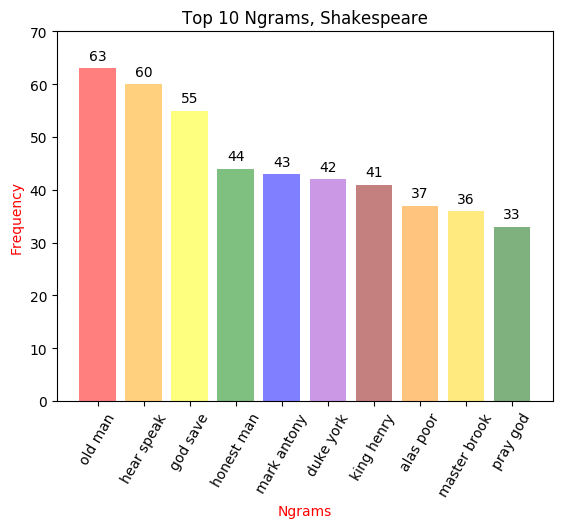

In [14]:
# Variables
n = 10
outputFile = "ngramTopTenPlainText.svg"
fmt = 'svg'
dpi = 300
angle = 60
title = 'Top 10 Ngrams, Shakespeare'
color = ['red','orange', 'yellow', 'green', 'blue','darkorchid', 'darkred', 'darkorange','gold', 'darkgreen']
labCol = 'red'
ngramStop = ["love love", "know know", "fie fie", "ha ha"]

# Ngram Stopwords
text = dfNG[~dfNG['ngrams'].isin(ngramStop)]
dfTN = text[0:n]

# Plot
plt.rcdefaults()

plt.bar(dfTN['ngrams'], dfTN['freq'], align = 'center', alpha = 0.5, color = color)
    

        
plt.xticks(dfTN['ngrams'])
plt.xticks(rotation = angle)
        
xlabel = plt.xlabel('Ngrams')
xlabel.set_color(labCol)
ylabel = plt.ylabel('Frequency')
ylabel.set_color(labCol)
    
high = max(dfTN['freq'])
low = 0
    
plt.ylim(low, math.ceil(high + 0.1 * (high - low)))
    
for xpos, count in zip(dfTN['ngrams'], dfTN['freq']):
    
    plt.text(x = xpos, y = count + 1, s = str(count), ha = 'center', va = 'bottom')

plt.title(title)
 
plt.savefig(os.path.join(dataResults, outputFile), format = fmt, dpi = dpi, bbox_inches = 'tight')
    
plt.show()

## VOILA!!